# BERT Baseline for Figurative Language Understanding

In this notebook, we prepare a BERT-based baseline model for the BESSTIE dataset.
We use the preprocessed encoder-ready data produced earlier and focus on:

- Loading preprocessed tensors
- Understanding their structure
- Preparing datasets and dataloaders
- Verifying that everything is ready for training

## Imports and environment setup

We import the libraries required for:
- loading PyTorch tensors
- building datasets and dataloaders
- defining a BERT classification model
- basic evaluation utilities

No training is performed yet.

In [1]:
# Core libraries
import torch
import numpy as np
import random

# PyTorch utilities
from torch.utils.data import Dataset, DataLoader

# Hugging Face model
from transformers import BertForSequenceClassification

# Metrics
from sklearn.metrics import accuracy_score, f1_score

In [2]:
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch version: 2.9.0+cu126
CUDA available: True


## Reproducibility

We fix random seeds to ensure reproducible results.
This is important for fair comparison with other models and experiments.

In [3]:
# Fix random seeds
SEED = 50

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Random seeds fixed.")

Random seeds fixed.


In [4]:
# Simple check: generate a random number twice
print(np.random.rand())
print(np.random.rand())

0.49460164553802144
0.22808310444933622


## Loading preprocessed encoder data

We load the encoder-ready tensors created during preprocessing.
These tensors already include:
- input_ids
- attention_mask
- labels
- variety
- source

The data is split into train, validation, and test sets.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive mounted.")

Mounted at /content/drive
Google Drive mounted.


In [6]:
# Path to preprocessed data
DATA_PATH = "/content/drive/MyDrive/DNLP/data/processed_data/sentiment_bert_encoder_data.pt"

# Load the data
encoder_data = torch.load(DATA_PATH)

print("Keys in loaded data:", encoder_data.keys())

Keys in loaded data: dict_keys(['train', 'val', 'test'])


In [7]:
# Check split sizes
for split in encoder_data:
    print(
        split,
        encoder_data[split]["input_ids"].shape,
        encoder_data[split]["labels"].shape,
        encoder_data[split]["variety"].shape,
        encoder_data[split]["source"].shape
    )

train torch.Size([7979, 256]) torch.Size([7979]) torch.Size([7979]) torch.Size([7979])
val torch.Size([887, 256]) torch.Size([887]) torch.Size([887]) torch.Size([887])
test torch.Size([1212, 256]) torch.Size([1212]) torch.Size([1212]) torch.Size([1212])


## Inspecting tensor structure

Before modeling, we inspect the shape and content of tensors
to confirm that preprocessing was applied correctly.

We check:
- sequence length (max_length)
- label format
- attention masks
- variety
- source

In [8]:
# Inspect one training example
sample_input_ids = encoder_data["train"]["input_ids"][0]
sample_attention_mask = encoder_data["train"]["attention_mask"][0]
sample_label = encoder_data["train"]["labels"][0]
sample_variety = encoder_data["train"]["variety"][0]
sample_source = encoder_data["train"]["source"][0]

print("Input IDs shape:", sample_input_ids.shape)
print("Attention mask shape:", sample_attention_mask.shape)
print("Label:", sample_label)
print("Variety:", sample_variety)
print("Source:", sample_source)

Input IDs shape: torch.Size([256])
Attention mask shape: torch.Size([256])
Label: tensor(1)
Variety: tensor(1)
Source: tensor(0)


In [9]:
sample_input_ids

tensor([  101, 18770, 12477,  1306,  1605,   117,  1103,  1436,   119,  5055,
         1240,   171,  5658,  3171,  1105,  1198,  6657,  1175,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [10]:
sample_attention_mask

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [11]:
sample_label

tensor(1)

In [12]:
# Verify attention mask consistency
print("Number of real tokens:", sample_attention_mask.sum().item())
print("Total sequence length:", sample_attention_mask.shape[0])

Number of real tokens: 19
Total sequence length: 256


## Dataset class

We define a simple PyTorch Dataset to wrap the preprocessed tensors.
This allows us to use PyTorch DataLoader for batching.

The dataset does NOT perform tokenization.
It only returns already-prepared tensors.

In [13]:
class BertDataset(Dataset):
    def __init__(self, split_data):
        self.input_ids = split_data["input_ids"]
        self.attention_mask = split_data["attention_mask"]
        self.labels = split_data["labels"]
        self.variety = split_data["variety"]
        self.source = split_data["source"]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx],
            "variety": self.variety[idx],
            "source": self.source[idx]
        }

In [14]:
train_dataset = BertDataset(encoder_data["train"])
print("Number of training samples:", len(train_dataset))
print("Keys returned by dataset:", train_dataset[0].keys())

Number of training samples: 7979
Keys returned by dataset: dict_keys(['input_ids', 'attention_mask', 'labels', 'variety', 'source'])


## DataLoaders

We create DataLoaders for batching.
At this stage, we only test small batches to verify correctness.

In [15]:
BATCH_SIZE = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print("Train DataLoader ready.")

Train DataLoader ready.


In [16]:
# Fetch one batch
batch = next(iter(train_loader))

for key in batch:
    print(key, batch[key].shape)

input_ids torch.Size([8, 256])
attention_mask torch.Size([8, 256])
labels torch.Size([8])
variety torch.Size([8])
source torch.Size([8])


## Loading BERT for sequence classification

We load a pretrained BERT model with a classification head.
The model is configured for binary classification.

No training is performed in this cell.

In [17]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels=2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model loaded on device:", device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on device: cuda


In [18]:
# Count trainable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {num_params:,}")

Trainable parameters: 108,311,810


## Sanity check: forward pass

Before training, we perform a single forward pass on one batch.
This ensures:
- no shape mismatch
- no device errors
- correct output format

In [20]:
model.eval()

batch = next(iter(train_loader))

with torch.no_grad():
    outputs = model(
        input_ids=batch["input_ids"].to(device),
        attention_mask=batch["attention_mask"].to(device),
        labels=batch["labels"].to(device)
    )

print("Loss:", outputs.loss.item())
print("Logits shape:", outputs.logits.shape)

Loss: 1.0164234638214111
Logits shape: torch.Size([8, 2])


In [21]:
# Check that logits match expected shape
assert outputs.logits.shape[1] == 2
print("Forward pass successful. Shapes are correct.")

Forward pass successful. Shapes are correct.


## Status

At this point:
- Data loading is correct
- Tensor shapes are consistent
- DataLoaders work as expected
- BERT forward pass runs without errors

The notebook is ready for:
- defining loss functions (weighted or focal)
- training loop
- evaluation

We intentionally stop here before any heavy computation.

## Loading precomputed class weights

Class weights were computed during preprocessing and saved to ensure
consistent handling of class imbalance across experiments.

We load and reuse these weights here.

In [22]:
# Load class weights saved during preprocessing
WEIGHTS_PATH = "/content/drive/MyDrive/DNLP/data/processed_data/sentiment_weights.pt"
class_weights = torch.load(WEIGHTS_PATH).to(device)

print("Loaded class weights:", class_weights)

Loaded class weights: tensor([0.9912, 1.0090], device='cuda:0')


In [23]:
assert class_weights.shape[0] == 2
assert class_weights.min() > 0
print("Precomputed class weights verified.")

Precomputed class weights verified.


## Weighted Cross-Entropy Loss

This is the standard loss used to handle class imbalance.
Misclassifying minority-class samples results in a higher penalty.

In [24]:
weighted_loss_fn = torch.nn.CrossEntropyLoss(
    weight=class_weights.to(device)
)

print("Weighted loss function initialized.")

Weighted loss function initialized.


In [25]:
# Test loss on dummy logits
dummy_logits = torch.tensor([[2.0, 0.5]], device=device)
dummy_label = torch.tensor([1], device=device)

loss_value = weighted_loss_fn(dummy_logits, dummy_label)
print("Dummy weighted loss:", loss_value.item())

Dummy weighted loss: 1.7014133930206299


## Optimizer setup

We define the optimizer following the reference paper settings.
The optimizer is defined but not used yet.

In [26]:
from torch.optim import AdamW

optimizer = AdamW(
    model.parameters(),
    lr=2e-5,
    weight_decay=0.01
)

print("Optimizer initialized.")

Optimizer initialized.


In [27]:
# Check optimizer has parameters
param_groups = sum(len(g["params"]) for g in optimizer.param_groups)
print("Number of parameter groups:", param_groups)

Number of parameter groups: 201


## Evaluation metrics

We define helper functions to compute accuracy and macro F1.
These metrics are used consistently across experiments.

In [28]:
def compute_metrics(logits, labels):
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")

    return acc, f1

In [29]:
dummy_logits = torch.tensor([[0.2, 0.8], [0.6, 0.4]])
dummy_labels = torch.tensor([1, 0])

acc, f1 = compute_metrics(dummy_logits, dummy_labels)
print("Accuracy:", acc)
print("Macro F1:", f1)

Accuracy: 1.0
Macro F1: 1.0


## Sanity check: metrics on one batch

Before full training, we test metric computation on a single batch.
This ensures that logits, labels, and metrics are compatible.

In [30]:
model.eval()
batch = next(iter(train_loader))

with torch.no_grad():
    outputs = model(
        input_ids=batch["input_ids"].to(device),
        attention_mask=batch["attention_mask"].to(device)
    )

acc, f1 = compute_metrics(
    outputs.logits,
    batch["labels"].to(device)
)

print("Batch accuracy:", acc)
print("Batch macro F1:", f1)

Batch accuracy: 0.625
Batch macro F1: 0.38461538461538464


In [31]:
assert 0.0 <= acc <= 1.0
assert 0.0 <= f1 <= 1.0
print("Metric computation successful.")

Metric computation successful.


## Training configuration

We define all training hyperparameters in one place.
This makes experiments easy to reproduce and modify.

In [32]:
# Training configuration
NUM_EPOCHS = 1          # sanity run (will increase later)
LEARNING_RATE = 2e-5
BATCH_SIZE = 16
LOG_INTERVAL = 10       # how often to print loss

print("Training configuration set.")

Training configuration set.


In [33]:
assert NUM_EPOCHS >= 1
assert LEARNING_RATE > 0
print("Training config verified.")

Training config verified.


## Training loop

We define a simple training loop for BERT.
At this stage, we only support:
- weighted cross-entropy loss
- single-GPU or CPU training

This loop will be reused for all experiments.

In [34]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0.0

    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        # Move data to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Compute loss
        loss = loss_fn(outputs.logits, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [35]:
print("Training loop function defined.")

Training loop function defined.


## Validation loop

The validation loop evaluates the model without updating weights.
We compute accuracy and macro F1.

In [36]:
def evaluate(model, dataloader, device):
    model.eval()

    all_logits = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            all_logits.append(outputs.logits)
            all_labels.append(labels)

    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    acc, f1 = compute_metrics(all_logits, all_labels)
    return acc, f1

In [37]:
print("Evaluation loop function defined.")

Evaluation loop function defined.


## Validation DataLoader

We prepare a DataLoader for the validation split.

In [38]:
val_dataset = BertDataset(encoder_data["val"])

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Validation DataLoader ready.")

Validation DataLoader ready.


In [39]:
batch = next(iter(val_loader))
for k in batch:
    print(k, batch[k].shape)

input_ids torch.Size([16, 256])
attention_mask torch.Size([16, 256])
labels torch.Size([16])
variety torch.Size([16])
source torch.Size([16])


## Time logging utilities

We define helper functions to log elapsed time during training.
This helps us understand computational cost and compare experiments.

In [40]:
import time

def format_time(seconds):
    """Convert seconds to hh:mm:ss format."""
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{secs:02d}"

---

In [43]:
import copy
import time
import os
import torch
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader

# --- 1. Utility to Filter Data by Source ---
def filter_data_by_source(data_split, source_id):
    """
    Filters the tensors in the dictionary based on the 'source' column.
    """
    # Find indices where source == source_id
    indices = (data_split["source"] == source_id).nonzero(as_tuple=True)[0]

    filtered_data = {}
    for key in data_split:
        if isinstance(data_split[key], torch.Tensor):
            filtered_data[key] = data_split[key][indices]
        else:
            filtered_data[key] = data_split[key] # Copy metadata

    return filtered_data

# --- 2. Training & Eval Functions ---
def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{secs:02d}"

def compute_metrics(logits, labels):
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    return acc, f1

def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0.0

    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            all_logits.append(outputs.logits)
            all_labels.append(labels)

    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    return compute_metrics(all_logits, all_labels)

# Configuration shared by both cells
CHECKPOINT_DIR = "/content/drive/MyDrive/DNLP/checkpoints"
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

In [44]:
# --- Configuration for Google ---
SOURCE_NAME = "Google"
SOURCE_ID = 0  # CORRECTED: 0 is Google
NUM_EPOCHS = 30
LEARNING_RATE = 2e-5
BATCH_SIZE = 16
PATIENCE = 5

print(f"\n{'='*40}")
print(f"  Training {SOURCE_NAME} Model (ID: {SOURCE_ID})")
print(f"{'='*40}\n")

# 1. Filter Data
train_sub = filter_data_by_source(encoder_data["train"], SOURCE_ID)
val_sub = filter_data_by_source(encoder_data["val"], SOURCE_ID)

if len(train_sub["labels"]) > 0:
    train_ds = BertDataset(train_sub)
    val_ds = BertDataset(val_sub)
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Training samples: {len(train_ds)}")

    # 2. Setup Model & Loss
    # Using the global 'class_weights' variable as requested
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

    model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

    # 3. Training Loop
    history_google = {"train_loss": [], "val_acc": [], "val_f1": []}
    best_val_f1 = 0.0
    epochs_no_improve = 0
    save_path = f"{CHECKPOINT_DIR}/best_bert_sentiment_google.pt"

    epoch_bar = tqdm(range(1, NUM_EPOCHS + 1), desc=f"{SOURCE_NAME} Training", unit="epoch")

    for epoch in epoch_bar:
        train_loss = train_one_epoch(model, train_dl, optimizer, loss_fn, device)
        val_acc, val_f1 = evaluate(model, val_dl, device)

        history_google["train_loss"].append(train_loss)
        history_google["val_acc"].append(val_acc)
        history_google["val_f1"].append(val_f1)

        epoch_bar.set_postfix({"loss": f"{train_loss:.4f}", "val_f1": f"{val_f1:.4f}"})

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch}.")
            break

    print(f"Best Google F1: {best_val_f1:.4f}")
    torch.save(history_google, f"{CHECKPOINT_DIR}/history_sentiment_google.pt")

    # Clean up
    del model, optimizer
    torch.cuda.empty_cache()

else:
    print(f"No {SOURCE_NAME} data found! Check source ID.")


  Training Google Model (ID: 0)

Training samples: 3982


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Google Training:   0%|          | 0/30 [00:00<?, ?epoch/s]


Early stopping at epoch 6.
Best Google F1: 0.9128


In [45]:
# --- Configuration for Reddit ---
SOURCE_NAME = "Reddit"
SOURCE_ID = 1  # CORRECTED: 1 is Reddit
NUM_EPOCHS = 30
LEARNING_RATE = 2e-5
BATCH_SIZE = 16
PATIENCE = 5

print(f"\n{'='*40}")
print(f"  Training {SOURCE_NAME} Model (ID: {SOURCE_ID})")
print(f"{'='*40}\n")

# 1. Filter Data
train_sub = filter_data_by_source(encoder_data["train"], SOURCE_ID)
val_sub = filter_data_by_source(encoder_data["val"], SOURCE_ID)

if len(train_sub["labels"]) > 0:
    train_ds = BertDataset(train_sub)
    val_ds = BertDataset(val_sub)
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Training samples: {len(train_ds)}")

    # 2. Setup Model & Loss
    # Using the global 'class_weights' variable as requested
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

    model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

    # 3. Training Loop
    history_reddit = {"train_loss": [], "val_acc": [], "val_f1": []}
    best_val_f1 = 0.0
    epochs_no_improve = 0
    save_path = f"{CHECKPOINT_DIR}/best_bert_sentiment_reddit.pt"

    epoch_bar = tqdm(range(1, NUM_EPOCHS + 1), desc=f"{SOURCE_NAME} Training", unit="epoch")

    for epoch in epoch_bar:
        train_loss = train_one_epoch(model, train_dl, optimizer, loss_fn, device)
        val_acc, val_f1 = evaluate(model, val_dl, device)

        history_reddit["train_loss"].append(train_loss)
        history_reddit["val_acc"].append(val_acc)
        history_reddit["val_f1"].append(val_f1)

        epoch_bar.set_postfix({"loss": f"{train_loss:.4f}", "val_f1": f"{val_f1:.4f}"})

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch}.")
            break

    print(f"Best Reddit F1: {best_val_f1:.4f}")
    torch.save(history_reddit, f"{CHECKPOINT_DIR}/history_sentiment_reddit.pt")

    # Clean up
    del model, optimizer
    torch.cuda.empty_cache()

else:
    print(f"No {SOURCE_NAME} data found! Check source ID.")


  Training Reddit Model (ID: 1)

Training samples: 3997


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Reddit Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Best Reddit F1: 0.8150


In [46]:
import pandas as pd

# --- Configuration ---
BATCH_SIZE = 16
CHECKPOINT_DIR = "/content/drive/MyDrive/DNLP/checkpoints"

# Define the paths to the saved best models
model_paths = {
    "Google": f"{CHECKPOINT_DIR}/best_bert_sentiment_google.pt",
    "Reddit": f"{CHECKPOINT_DIR}/best_bert_sentiment_reddit.pt"
}

# Source IDs (Remember: 0=Google, 1=Reddit based on your correction)
source_ids = {"Google": 0, "Reddit": 1}

print(f"{'='*60}")
print("  STARTING FINAL EVALUATION & CROSS-DOMAIN CHECK")
print(f"{'='*60}\n")

results = []

# Loop through each trained model
for model_name, model_path in model_paths.items():
    if not os.path.exists(model_path):
        print(f"⚠️ Warning: Checkpoint for {model_name} not found at {model_path}. Skipping.")
        continue

    print(f"Loading best {model_name} model...")

    # Load Model Architecture
    model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
    # Load Trained Weights
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval() # Set to evaluation mode

    # --- Test on Both Domains ---
    for test_source_name, test_source_id in source_ids.items():
        print(f"  Testing {model_name} model on {test_source_name} test data...")

        # 1. Filter Test Data
        test_sub = filter_data_by_source(encoder_data["test"], test_source_id)

        if len(test_sub["labels"]) == 0:
            print(f"    No test data found for {test_source_name}.")
            continue

        # 2. Create DataLoader
        test_ds = BertDataset(test_sub)
        test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

        # 3. Evaluate
        acc, f1 = evaluate(model, test_dl, device)

        print(f"    -> Accuracy: {acc:.4f} | F1 Score: {f1:.4f}")

        # Store result
        results.append({
            "Trained On": model_name,
            "Tested On": test_source_name,
            "Accuracy": acc,
            "F1 Score": f1,
            "Type": "Same Domain" if model_name == test_source_name else "Cross Domain"
        })

    print("-" * 40)

    # Clean up
    del model
    torch.cuda.empty_cache()

# --- Display Summary Table ---
print("\nFinal Results Summary:")
df_results = pd.DataFrame(results)
display(df_results)

  STARTING FINAL EVALUATION & CROSS-DOMAIN CHECK

Loading best Google model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Testing Google model on Google test data...
    -> Accuracy: 0.9154 | F1 Score: 0.8845
  Testing Google model on Reddit test data...
    -> Accuracy: 0.7980 | F1 Score: 0.7449
----------------------------------------
Loading best Reddit model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Testing Reddit model on Google test data...
    -> Accuracy: 0.8557 | F1 Score: 0.7837
  Testing Reddit model on Reddit test data...
    -> Accuracy: 0.8703 | F1 Score: 0.8280
----------------------------------------

Final Results Summary:


,Trained On,Tested On,Accuracy,F1 Score,Type
0,Google,Google,0.915423,0.884502,Same Domain
1,Google,Reddit,0.798030,0.744865,Cross Domain
2,Reddit,Google,0.855721,0.783670,Cross Domain
3,Reddit,Reddit,0.870279,0.827977,Same Domain


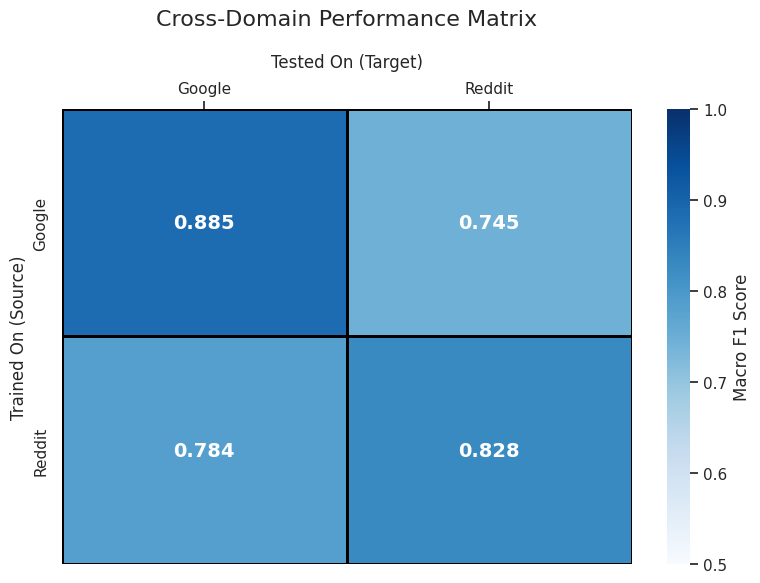

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pivot the data for the heatmap
# Rows = Trained On, Columns = Tested On, Values = F1 Score
heatmap_data = df_results.pivot(index="Trained On", columns="Tested On", values="F1 Score")

# Set up the figure
plt.figure(figsize=(8, 6))
sns.set_theme(style="white")

# Draw the heatmap
ax = sns.heatmap(
    heatmap_data,
    annot=True,           # Write the numbers in the boxes
    fmt=".3f",            # Format to 3 decimal places
    cmap="Blues",         # Color scheme (Darker = Higher Score)
    vmin=0.5, vmax=1.0,   # Set range so colors are meaningful
    cbar_kws={'label': 'Macro F1 Score'},
    annot_kws={"size": 14, "weight": "bold"}, # Make numbers big and bold
    linewidths=1,         # Add gaps between squares
    linecolor='black'
)

# Move X-axis labels to top for better readability (Matrix style)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

# Titles and Labels
plt.title("Cross-Domain Performance Matrix", fontsize=16, pad=20)
plt.xlabel("Tested On (Target)", fontsize=12, labelpad=10)
plt.ylabel("Trained On (Source)", fontsize=12)

plt.tight_layout()
plt.show()

  PER-VARIETY EVALUATION (GOOGLE & REDDIT)

Evaluating Google Model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  -> en-AU: F1=0.8872
  -> en-IN: F1=0.8200
  -> en-UK: F1=0.9362
------------------------------
Evaluating Reddit Model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  -> en-AU: F1=0.8664
  -> en-IN: F1=0.7650
  -> en-UK: F1=0.8403
------------------------------


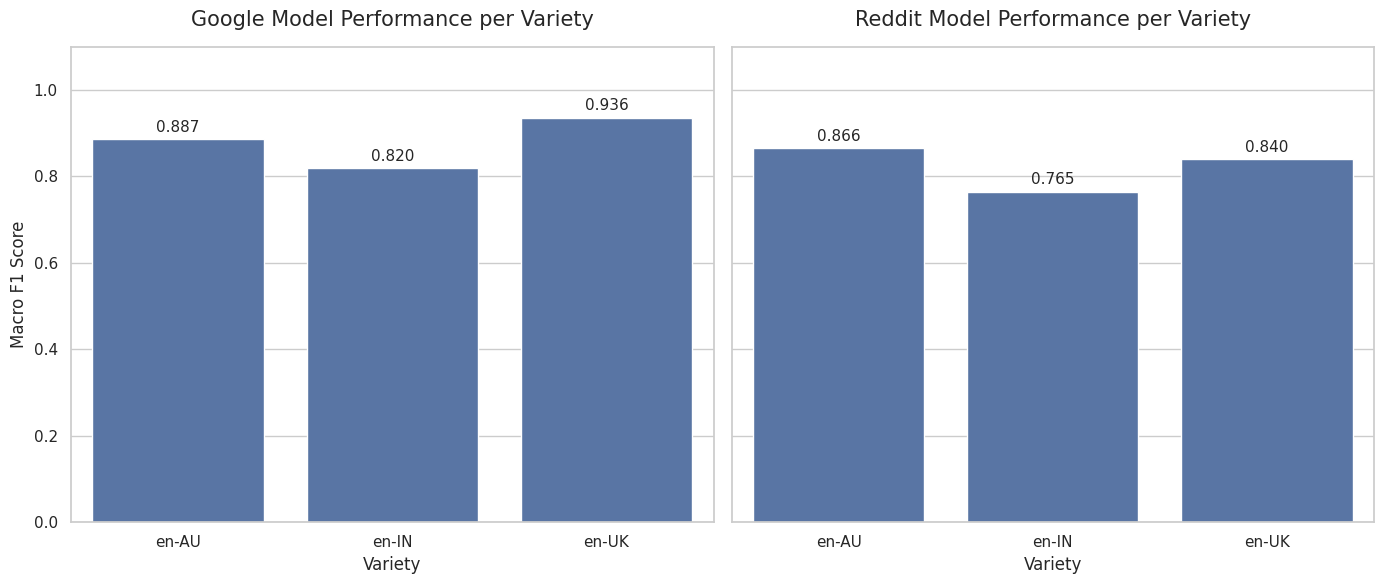

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader

# --- 1. Setup ---
VARIETY_MAPPING = {0: "en-AU", 1: "en-IN", 2: "en-UK"}

def filter_source_variety(data, source_id, variety_id):
    """Filters data by both source and variety."""
    mask = (data["source"] == source_id) & (data["variety"] == variety_id)
    indices = mask.nonzero(as_tuple=True)[0]
    filtered = {}
    for key in data:
        if isinstance(data[key], torch.Tensor):
            filtered[key] = data[key][indices]
        else:
            filtered[key] = data[key]
    return filtered

# --- 2. Evaluation Loop ---
results_per_variety = []

print(f"{'='*60}")
print("  PER-VARIETY EVALUATION (GOOGLE & REDDIT)")
print(f"{'='*60}\n")

for model_name, model_path in model_paths.items():
    if not os.path.exists(model_path):
        print(f"Skipping {model_name}, checkpoint not found.")
        continue

    print(f"Evaluating {model_name} Model...")

    # Load Model
    model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    source_id = source_ids[model_name] # 0=Google, 1=Reddit

    # Check each variety
    for var_id, var_name in VARIETY_MAPPING.items():
        subset = filter_source_variety(encoder_data["test"], source_id, var_id)

        if len(subset["labels"]) == 0:
            print(f"  No data for {var_name}")
            continue

        ds = BertDataset(subset)
        dl = DataLoader(ds, batch_size=16, shuffle=False)
        acc, f1 = evaluate(model, dl, device)

        results_per_variety.append({
            "Dataset": model_name,
            "Variety": var_name,
            "F1 Score": f1
        })
        print(f"  -> {var_name}: F1={f1:.4f}")

    # Cleanup
    del model
    torch.cuda.empty_cache()
    print("-" * 30)

df_variety = pd.DataFrame(results_per_variety)

# --- 3. Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
sns.set_theme(style="whitegrid")

# Google Plot
sns.barplot(
    data=df_variety[df_variety["Dataset"] == "Google"],
    x="Variety",
    y="F1 Score",
    ax=axes[0]
    )
axes[0].set_title("Google Model Performance per Variety", fontsize=15, pad=15)
axes[0].set_xlabel("Variety", fontsize=12)
axes[0].set_ylabel("Macro F1 Score", fontsize=12)
axes[0].set_ylim(0, 1.1)

# Add numbers
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.3f', padding=3, fontsize=11)

# Reddit Plot
sns.barplot(
    data=df_variety[df_variety["Dataset"] == "Reddit"],
    x="Variety",
    y="F1 Score",
    ax=axes[1]
    )
axes[1].set_title("Reddit Model Performance per Variety", fontsize=15, pad=15)
axes[1].set_xlabel("Variety", fontsize=12)
axes[1].set_ylabel("") # Shared Y axis

# Add numbers
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.3f', padding=3, fontsize=11)

plt.tight_layout()
plt.show()

Evaluating Google Model per variety...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  en-AU: F1 = 0.887
  en-IN: F1 = 0.820
  en-UK: F1 = 0.936
Evaluating Reddit Model per variety...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  en-AU: F1 = 0.866
  en-IN: F1 = 0.765
  en-UK: F1 = 0.840


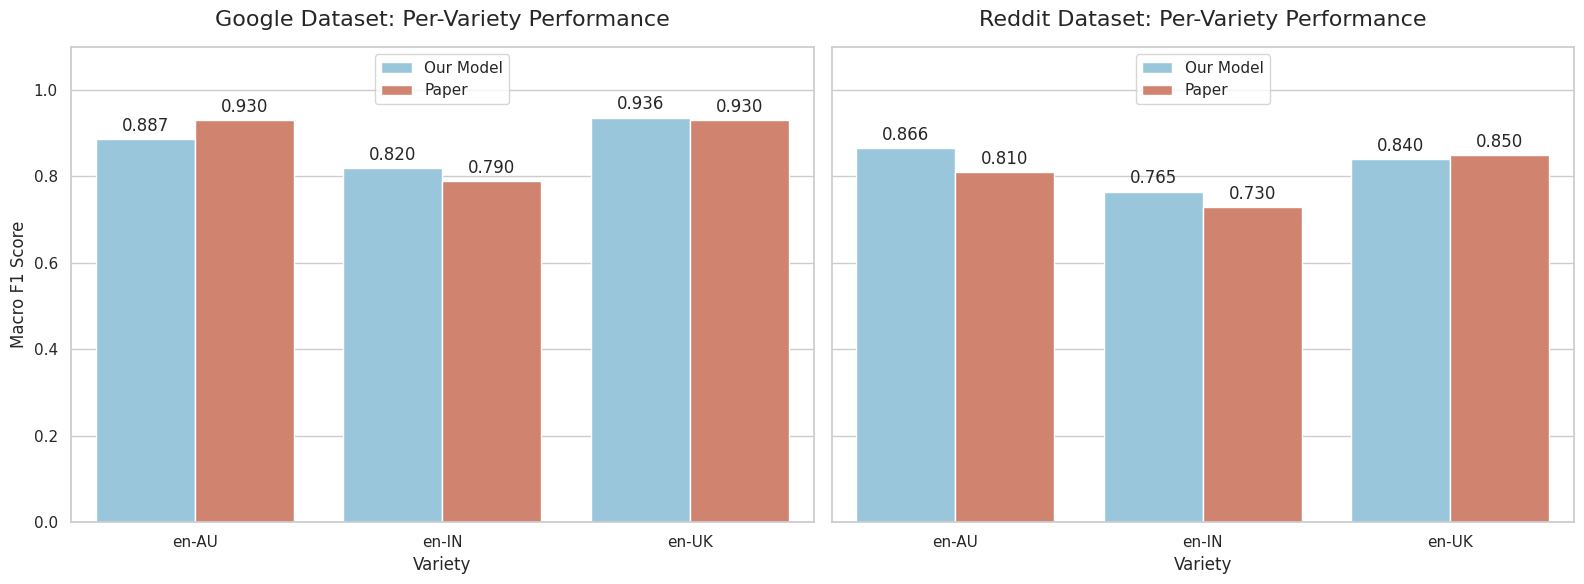

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader

# --- 1. Setup & Helper Functions ---
# Map the integer IDs to Variety Names (assuming standard alphabetical order)
VARIETY_MAPPING = {0: "en-AU", 1: "en-IN", 2: "en-UK"}

# Define Paper Results manually (from your image for BERT)
paper_results = {
    "Google": {"en-AU": 0.93, "en-IN": 0.79, "en-UK": 0.93},
    "Reddit": {"en-AU": 0.81, "en-IN": 0.73, "en-UK": 0.85}
}

def filter_by_source_and_variety(data_split, source_id, variety_id):
    """Filters data by BOTH source and variety."""
    # Create a boolean mask where both conditions are true
    mask = (data_split["source"] == source_id) & (data_split["variety"] == variety_id)
    indices = mask.nonzero(as_tuple=True)[0]

    filtered = {}
    for key in data_split:
        if isinstance(data_split[key], torch.Tensor):
            filtered[key] = data_split[key][indices]
        else:
            filtered[key] = data_split[key]
    return filtered

# --- 2. Calculate Your Model's Scores per Variety ---
detailed_results = []

# Loop over models (Google Model, Reddit Model)
for model_name, model_path in model_paths.items():
    if not os.path.exists(model_path):
        continue

    print(f"Evaluating {model_name} Model per variety...")

    # Load Model
    model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    # Get the correct source ID for this model (evaluate Google model on Google data, etc.)
    source_id = source_ids[model_name]

    # Iterate through each variety
    for var_id, var_name in VARIETY_MAPPING.items():
        # Filter Test Data for this specific Source AND Variety
        subset = filter_by_source_and_variety(encoder_data["test"], source_id, var_id)

        if len(subset["labels"]) == 0:
            print(f"  No data for {var_name}")
            continue

        # Create Loader & Evaluate
        ds = BertDataset(subset)
        dl = DataLoader(ds, batch_size=16, shuffle=False)
        acc, f1 = evaluate(model, dl, device)

        print(f"  {var_name}: F1 = {f1:.3f}")

        # Add "Our Model" result
        detailed_results.append({
            "Dataset": model_name, # Google or Reddit
            "Variety": var_name,
            "Type": "Our Model",
            "F1 Score": f1
        })

        # Add "Paper" result (for comparison)
        detailed_results.append({
            "Dataset": model_name,
            "Variety": var_name,
            "Type": "Paper",
            "F1 Score paper_val": paper_results[model_name].get(var_name, 0)
        })
        # Note: I used a different key above temporarily to avoid confusion,
        # let's clean that up for the dataframe construction below.

# Re-structuring list for DataFrame to ensure clean plotting
final_plot_data = []
for item in detailed_results:
    # Rename keys to be uniform
    entry = {
        "Dataset": item["Dataset"],
        "Variety": item["Variety"],
        "Type": item["Type"],
        "F1 Score": item.get("F1 Score") if "F1 Score" in item else item.get("F1 Score paper_val")
    }
    final_plot_data.append(entry)

df_variety = pd.DataFrame(final_plot_data)

# --- 3. Plotting the Charts ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
sns.set_theme(style="whitegrid")

# Colors: Light Blue for Us, Red/Pink for Paper (matching your upload roughly)
palette = {"Our Model": "#8ecae6", "Paper": "#e07a5f"}

# -- Plot 1: Google --
sns.barplot(
    data=df_variety[df_variety["Dataset"] == "Google"],
    x="Variety",
    y="F1 Score",
    hue="Type",
    palette=palette,
    ax=axes[0]
)
axes[0].set_title("Google Dataset: Per-Variety Performance", fontsize=16, pad=15)
axes[0].set_xlabel("Variety", fontsize=12)
axes[0].set_ylabel("Macro F1 Score", fontsize=12)
axes[0].set_ylim(0, 1.1)
axes[0].legend(loc="upper center")

for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.3f', padding=3)

# -- Plot 2: Reddit --
sns.barplot(
    data=df_variety[df_variety["Dataset"] == "Reddit"],
    x="Variety",
    y="F1 Score",
    hue="Type",
    palette=palette,
    ax=axes[1]
)
axes[1].set_title("Reddit Dataset: Per-Variety Performance", fontsize=16, pad=15)
axes[1].set_xlabel("Variety", fontsize=12)
axes[1].set_ylabel("") # Shared Y axis
axes[1].legend(loc="upper center")

for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()